In [2]:
pip install regex seaborn scikit-learn tokenizers transformers pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip uninstall googletrans -y
!pip install googletrans==4.0.0rc1
import googletrans
print(googletrans.__version__)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17414 sha256=e656b882bf84e75f49a31b2a92e2406f6f7d435b1af6ae7d5fac13cac19a5827
  Stored in directory: /root/.cache/pip/wheels/db/fa/af/f0b5170b729c1b212a6270b14108c96c814f21e95da037fbad
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-

In [4]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter
import pythainlp
import re
from googletrans import Translator

import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [6]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 1

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [7]:
df = pd.read_csv('/kaggle/input/hackathon-online-fake-news-classification/train.csv')
df.head()

,id,text,language,label
0,GZsDkNhz42u4SAzbAnUouC,"Last month, Mr. McLaren delivered a preliminar...",english,Real
1,jaRxYZgqXRNrxZiPiLT6xy,JOHANNESBURG (Reuters) - Leaders of Zimbabwe s...,english,Real
2,nYUyyPh5R5zxs8dPa4p6XY,“But our real goal is to reach the stage when ...,english,Real
3,myF2ZaAj2ekwKxuoN8fprG,BEN CARSON fearlessly explain the TRUTH behind...,english,Fake
4,DUQVYqAz4W6EZBy2CFevZq,They just spent big bucks on a new headquarter...,english,Fake


In [8]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

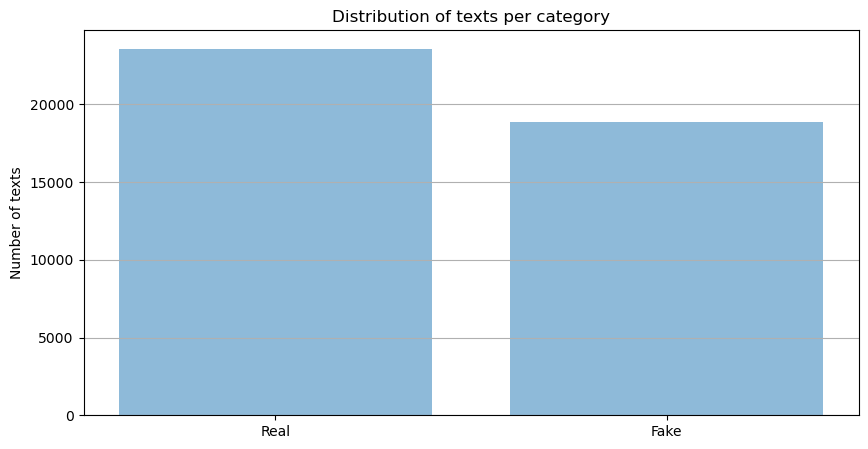

Counter({'Real': 23583, 'Fake': 18867})


In [9]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
        
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')
        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

In [ ]:
display_lengths_histograms(df_stats)

In [10]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

Texts in dataset: 42450
Number of categories: 2


In [ ]:
def is_thai(text):
    # Check if text contains Thai characters using PyThaiNLP
    thai_characters = set(pythainlp.thai_characters)
    return any(char in thai_characters for char in text)

def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize English text with the RobertaTokenizer
        if not is_thai(text):
            tok_text = tokenizer.tokenize(text)
            enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
            input_length = len(enc_text) + 2
            input_length = input_length if input_length < MAX_LEN else MAX_LEN
            input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
            attention_mask[k,:input_length] = 1
        # Tokenize Thai text using PyThaiNLP
        else:
            tok_text = pythainlp.tokenize.word_tokenize(text, engine='newmm')
            enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
            input_length = len(enc_text) + 2
            input_length = input_length if input_length < MAX_LEN else MAX_LEN
            input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
            attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
from googletrans import Translator

In [11]:
# def is_thai(text):
#     # Check if text contains Thai characters using PyThaiNLP
#     thai_characters = set(pythainlp.thai_characters)
#     return any(char in thai_characters for char in text)

def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32')
    
    # Create a translator object
#     translator = Translator()

    for k, text in enumerate(texts):
        
#         if not is_thai(text):
#        # Split the text to remove specified characters
        translated_text = re.sub(r'[\*\%\^\$\&\#\(\)\@\-\—\:\,\+\=\!]+', ' ',text)
            
#         else:
        # Translate the text to English
#         translated_text = str(translator.translate(text).text)  
         
        # Tokenize
        tok_text = tokenizer.tokenize(translated_text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32')

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [12]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'Real', 1: 'Fake'}

In [13]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=777)

In [14]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train

In [15]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [16]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [17]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=1,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
13142/33960 [==========>...................] - ETA: 24:43 - loss: 0.1421 - accuracy: 0.9473

In [17]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 98.07%


133/133 [==============================] - 4s 24ms/step


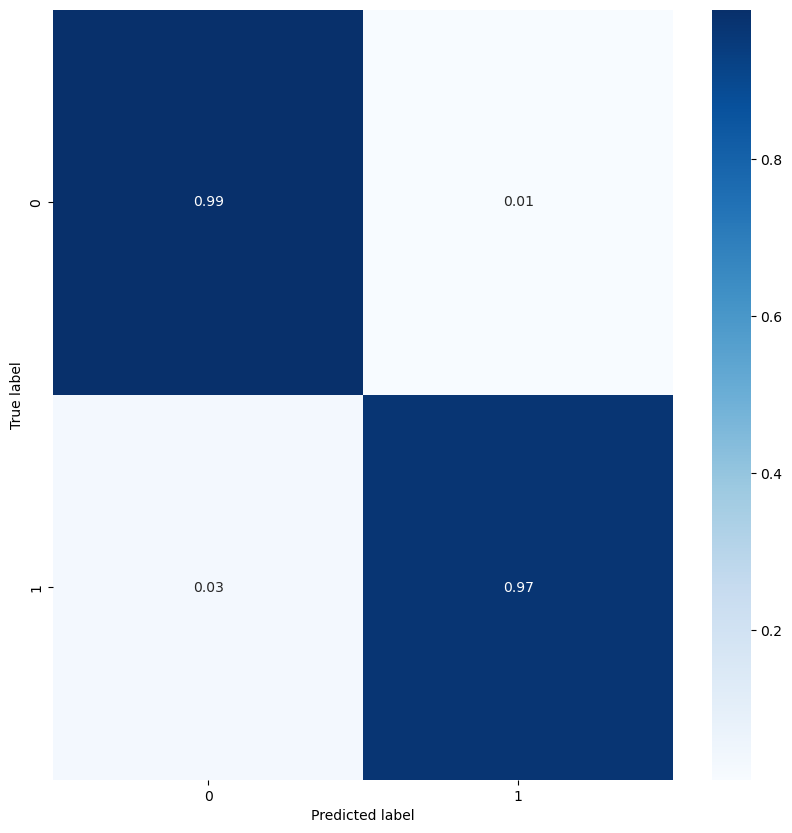

In [19]:
plot_confusion_matrix(X_test, y_test, model)

In [20]:
df_sub = pd.read_csv('/kaggle/input/hackathon-online-fake-news-classification/test.csv')
df_sub.head()

,id,text,language
0,63e2vyej6oXukEfDdoGuA5,"— Holger Stark (@holger_stark) January 20, 2...",english
1,ZjYG72fdvd6JmazkS32ZFx,Can you hear us now?If they keep this up Disne...,english
2,ZYUhHXzaDxtncvd6nw8yiy,“I’ve witnessed him as a businessman sitting a...,english
3,HejAe5F5BGKD4HUYMT9DTg,"WASHINGTON (Sputnik) — Earlier in the day, loc...",english
4,5ZjAEKgz9RCsBykjtYyp4S,A world where our resources are applied creati...,english


In [21]:
X_sub = df_sub[['text']].to_numpy().reshape(-1)
X_sub = roberta_encode(X_sub, tokenizer)

In [23]:
test_pre = model.predict(X_sub)
pred_class = np.argmax(test_pre, axis=1)
pred_class

654/654 [==============================] - 16s 23ms/step


array([0, 1, 0, ..., 0, 0, 0])

In [24]:
prediction = []
for i in pred_class:
    if i == 0:
        prediction.append("Real")
    else:
        prediction.append("Fake")

In [ ]:
prediction

In [25]:
submit = pd.DataFrame({'id':df_sub["id"],
                      'label':prediction})

submit.to_csv('submission_6.csv', index=False)